In [1]:
#   Decomposing TS 
# https://www.machinelearningplus.com/time-series/time-series-analysis-python/
import pandas as pd
from pandas import Series
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline

# Import the check_stationarity function from previous lab
from statsmodels.tsa.stattools import adfuller
def stationarity_check(TS):
    # Calculate rolling statistics
    rolmean = TS.rolling(window = 9, center = False).mean()
    rolstd = TS.rolling(window = 9, center = False).std()

    # Perform the Dickey Fuller Test
    dftest = adfuller(TS) 

    ######Plot rolling statistics:
    fig = plt.figure(figsize=(15,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    ###### Print Dickey-Fuller test results
    print ('Results of Dickey-Fuller Test:')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    return None

#  stationary noise
def STSeries(tau): 
    x0 = np.random.normal(0,.1,tau)
    return x0

# non-stationary process with noise
import random
def NTSeries(tau,scada):
    limit_low = 0
    limit_high = scada/2
    Iodd =  random.randint(0, 1)
    xs = np.random.normal(scada/4, tau) \
          + np.abs(np.random.normal(0, scada/2, tau) \
                   * np.sin(np.linspace(0, (3 + Iodd)*scada, tau)) ) \
          + np.sin(np.linspace(0, (5 + Iodd)*scada, tau))**2 \
          + np.sin(np.linspace(1, (7 + Iodd)*scada, tau))**2
    scaling = (limit_high - limit_low) / (max(xs) - min(xs))
    xs = xs * scaling
    eta = np.random.rand(tau)
    xs = xs + eta
    xs = xs + (limit_low - min(xs))
    return xs

def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))

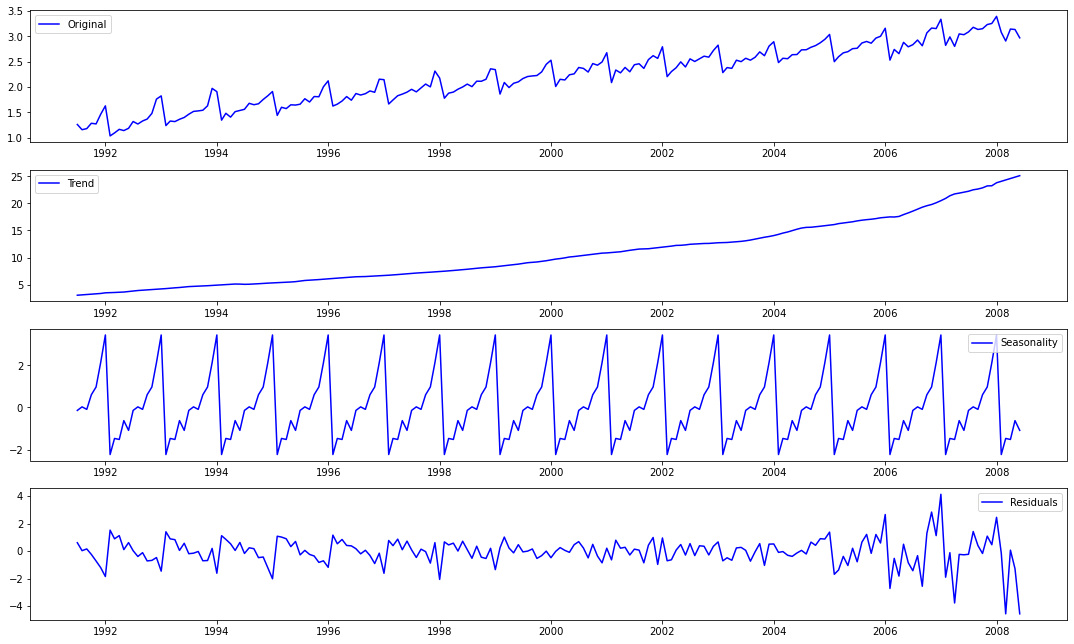

In [2]:
#   Import Data
import matplotlib.pyplot as plt
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/a10.csv', parse_dates=['date'], index_col='date')
#   time series is  split into the following components: 
    # Additive time series: Base Level + Trend + Seasonality + Error
    # Multiplicative Time Series:
    # Base Level x Trend x Seasonality x Error

# Additive Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

decomposition_add = seasonal_decompose(df['value'], model='additive', extrapolate_trend='freq')

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition_add.trend
seasonal = decomposition_add.seasonal
residual = decomposition_add.resid

# Plot gathered statistics
plt.figure(figsize=(15,9))
plt.subplot(411)
plt.plot(np.log(df), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

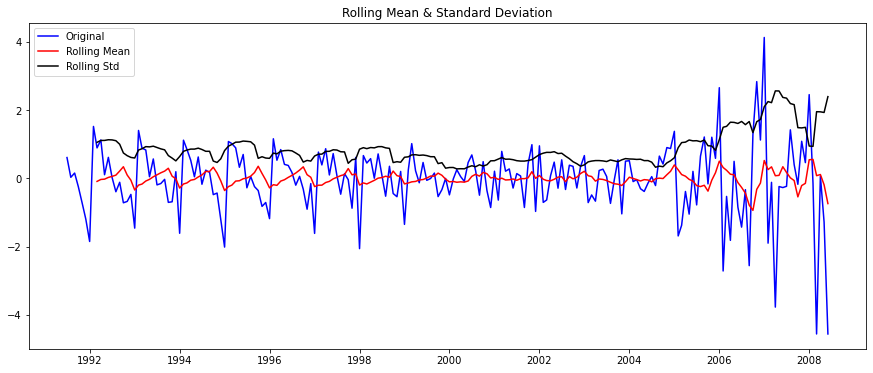

Results of Dickey-Fuller Test:
Test Statistic                -5.790057e+00
p-value                        4.896059e-07
#Lags Used                     1.400000e+01
Number of Observations Used    1.890000e+02
Critical Value (1%)           -3.465431e+00
Critical Value (5%)           -2.876957e+00
Critical Value (10%)          -2.574988e+00
dtype: float64


In [3]:
# check stationarity of residuals
###### Drop NaN values from residuals.
series = residual
series.dropna(inplace=True)
stationarity_check(series)

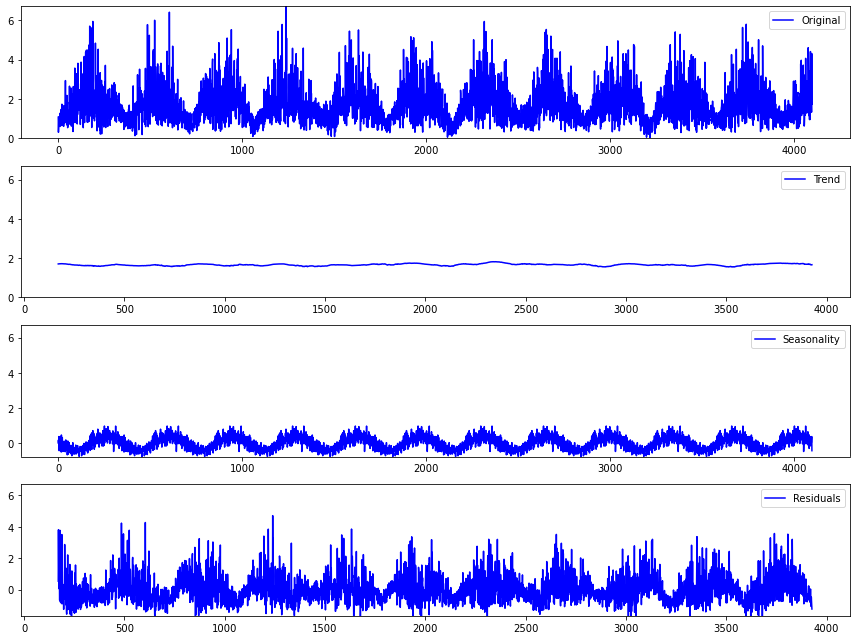

In [4]:
# main
np.random.seed(1234567)
tau = 4098
scada = 12

#  seasonal time series
xNonSt = NTSeries(tau, scada) 

tauu= int(tau/(scada))  # int(tau/12)
#  input data must have 2 complete cycles, period < tau/2
decomposition_add = seasonal_decompose(xNonSt,model='additive', period=tauu)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition_add.trend
seasonal = decomposition_add.seasonal
residual = decomposition_add.resid

# Plot gathered statistics
plt.figure(figsize=(12,9))
plt.subplot(411)
plt.ylim((min(xNonSt),max(xNonSt)))
plt.plot((xNonSt), label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.ylim((min(xNonSt),max(xNonSt)))
plt.plot((trend), label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.ylim((min(seasonal),max(xNonSt)))
plt.plot((seasonal),label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.ylim((-.25*max(xNonSt),max(xNonSt)))
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

[]

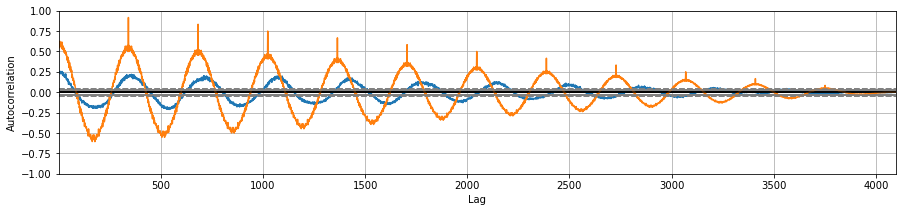

In [5]:
# Creating Autocorrelation plot
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(15,3))
R_x = pd.plotting.autocorrelation_plot(xNonSt)
R_s = pd.plotting.autocorrelation_plot(seasonal)  
R_r = pd.plotting.autocorrelation_plot(residual)  
# ploting the Curve
R_x.plot()
R_s.plot()
#R_r.plot()


In [13]:
# estimating the forecastability of a time series
print('original TS:',SampEn(xNonSt, m=2, r=0.2*np.std(xNonSt))) 
print('\n')
print('seasonal TS:',SampEn(seasonal, m=2, r=0.2*np.std(seasonal))) 
print('\n')
#print('detrended TS:',SampEn(residual, m=2, r=0.2*np.std(residual))) 

original TS: 1.7752339753710042


seasonal TS: 1.304823377418177




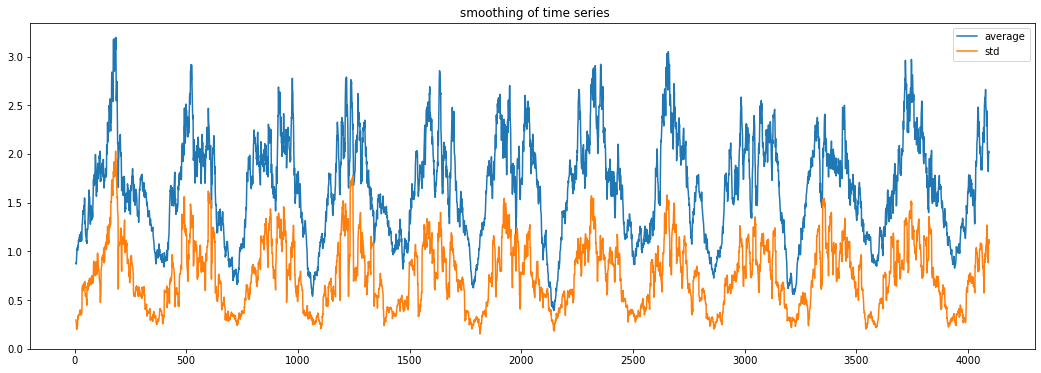

In [6]:
# smoothing of time series
from statsmodels.nonparametric.smoothers_lowess import lowess
# 1. Moving Average
tau_w = int(scada)
dataframe = pd.DataFrame(xNonSt)
rolmean1 = dataframe.rolling(tau_w, center=True, closed='both').mean() # moving average
rolmean2 = dataframe.rolling(tau_w, center=True, closed='both').std() # moving standard deviation
#rolmean3 = dataframe.rolling(tau_w, center=True, closed='both').skew() # moving skewness
#rolmean4 = dataframe.rolling(tau_w, center=True, closed='both').kurt() # moving kurtosis
plt.figure(figsize=(18,6))
plt.plot(rolmean1)
plt.plot(rolmean2)
#plt.plot(rolmean3)
#plt.plot(rolmean4)
plt.title(' smoothing of time series')
plt.legend(['average', 'std'])